In this notebook we implement the stage 1 of the phononet architecture in tensorflow. We use the phononet library to just extract the chromogram data.

In [1]:
import matplotlib.pyplot as plt
import json
from collections import Counter

%matplotlib inline

import sys
import os


In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
sys.path.append('../')

In [4]:
import phononet as pn

In [5]:
include_files = json.load(open('SankalpRagaDataset.json'))  # import list of song_ids to include
cd = pn.FullChromaDataset('hindustaniv2.json', '../../n_ftt4096__hop_length2048',
                          include_mbids=include_files)  # load dataset of "full song" chromagrams
train, test = cd.train_test_split(train_size=0.75)  # split training and test sets from "full song" chromagrams
train = pn.ChromaChunkDataset(train, chunk_size=1500)  # divide training set into chunks of width 150
test = pn.ChromaChunkDataset(test, chunk_size=1500)

Loading Chromagram Files: 100%|██████████| 300/300 [00:00<00:00, 1806.98it/s]


In [6]:
#raga_detector = pn.RagaDetector(batch_size=32, gpus=1)
#raga_detector.fit(train, test)

In [7]:
X_train=train.X.numpy()
y_train=np.array(train.y).astype(np.int8)

X_val=test.X.numpy()
y_val=np.array(test.y).astype(np.int8)

<BarContainer object of 30 artists>

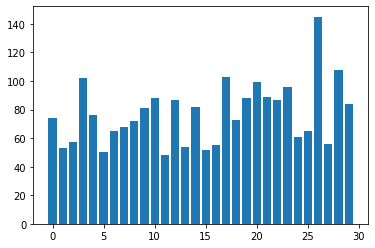

In [8]:
a,b=zip(*sorted(Counter(y_train).items(),key=lambda x:x[0]))
plt.bar(a,b)

In [9]:
from collections import Counter
counter=Counter(y_train)
weights=np.array([1/counter[val] for val in y_train])
weights/=weights.sum()
idxs=np.random.choice(range(len(y_train)),len(y_train),p=weights)

In [10]:
a,b=zip(*sorted(Counter(y_train[idxs]).items(),key=lambda x:x[0]))
plt.bar(a,b)

<BarContainer object of 30 artists>

In [11]:
def gen(X,y,augment,balanced):
    n=len(X)
    
    if balanced:
        counter=Counter(y)
        weights=np.array([1/counter[val] for val in y])
        weights/=weights.sum()
        idxs=np.random.choice(range(n),n,p=weights)
    else:
        idxs=list(range(n))
        
    offsets=np.random.randint(12,size=n)
    np.random.shuffle(idxs)
    
    l=list(range(12))
    
    ls=[]
    for i in range(12):
        ls.append(l[i:]+l[:i])
    
    for idx,i in zip(idxs,offsets):
        if augment:
            yield X[idx].take(ls[i],axis=0),y[idx]
        else:
            yield X[idx],y[idx]




In [12]:
BATCH_SIZE=32
AUGMENT=True
BALANCED=True
train_data=tf.data.Dataset.from_generator(generator=gen,args=(X_train,y_train,AUGMENT,BALANCED),
                                           output_shapes=(tf.TensorShape([12,1500]),tf.TensorShape([])),
                                           output_types=(tf.float32,tf.int8)
                                          ).repeat().batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(1000).batch(BATCH_SIZE)

In [13]:
class ConfusionMatrixMetric(tf.keras.metrics.Metric):
    """
    A custom Keras metric to compute the running average of the confusion matrix
    """
    def __init__(self, num_classes,print_f1=True,print_precision=False,print_recall=False, **kwargs):
        super(ConfusionMatrixMetric,self).__init__(name='confusion_matrix_metric',**kwargs) # handles base args (e.g., dtype)
        self.num_classes=num_classes
        self.total_cm = self.add_weight("total", shape=(num_classes,num_classes), initializer="zeros")
        self.print_f1=print_f1
        self.print_precision=print_precision
        self.print_recall=print_recall
        
    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))
            
    def update_state(self, y_true, y_pred,sample_weight=None):
        self.total_cm.assign_add(self.confusion_matrix(y_true,y_pred))
        return self.total_cm
        
    def result(self):
        return self.process_confusion_matrix()
    
    def confusion_matrix(self,y_true, y_pred):
        """
        Make a confusion matrix
        """
        y_pred=tf.argmax(y_pred,1)
        cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=self.num_classes)
        return cm
    
    def process_confusion_matrix(self):
        "returns precision, recall and f1 along with overall accuracy"
        cm=self.total_cm
        diag_part=tf.linalg.diag_part(cm)
        precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
        recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
        f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
        return precision,recall,f1
    
    def fill_output(self,output):
        results=self.result()
        for i in range(self.num_classes):
            if self.print_precision:
                output['precision_{}'.format(i)]=results[0][i]
            if self.print_recall:
                output['recall_{}'.format(i)]=results[1][i]
            if self.print_f1:
                output['F1_{}'.format(i)]=results[2][i]

In [14]:
class MySequential(keras.Sequential):
    
    def train_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            with tf.GradientTape() as tape:
                y_pred = self(x, training=True)  # Forward pass
                # Compute the loss value.
                # The loss function is configured in `compile()`.
                loss = self.compiled_loss(
                    y,
                    y_pred,
                    regularization_losses=self.losses,
                )

            # Compute gradients
            trainable_vars = self.trainable_variables
            gradients = tape.gradient(loss, trainable_vars)

            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))
            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
        
        
    def test_step(self, data):
            # Unpack the data. Its structure depends on your model and
            # on what you pass to `fit()`.
            
            x, y = data

            y_pred = self(x, training=False)  # Forward pass
            # Compute the loss value.
            # The loss function is configured in `compile()`.
            loss = self.compiled_loss(
                y,
                y_pred,
                regularization_losses=self.losses,
            )

            self.compiled_metrics.update_state(y, y_pred)
            #self.confusion_matrix_metric.update_state(y, y_pred)
            output={m.name: m.result() for m in self.metrics[:-1]}
            results = self.metrics[-1].result()
            for i in range(30):
                output['F1_{}'.format(i)]=results[2][i]
            return output
            


In [15]:
class PeriodicPaddingConv2D(keras.layers.Conv2D):
    
    # Note this ONLY works now for filter size 3 and stride of 1
    
    def __init__(self,*args,**kwargs):
        padding_val=kwargs.pop('padding',None)
        if padding_val=='same':
            print('For PeriodPaddingConv2D padding must be valid so setting it to valid.')
            
            # TODO: padding is the same in all directions and we thus loose length in the time direction
            # Should not be a big deal but we can change this by padding zeros explicitely.
            kwargs['padding']='valid'
        super().__init__(*args,**kwargs)
            
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        x=tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))
        return super().call(x)
    



In [16]:
from tensorflow.keras.layers import Conv2D

In [17]:
ConvLayer=Conv2D

In [18]:
dropout_prob=0.3
PADDING_TYPE='valid'
kernel_initializer='he_uniform'
leaky_relu_parameter=1e-2

model=MySequential([
    keras.layers.Input(shape=(12,1500)),
    keras.layers.Lambda(lambda x: tf.expand_dims(x,-1),name='expand_dims'),
    keras.layers.BatchNormalization(axis=[3],name='norm0'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(64,(3,3),name='conv1',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu1'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm1',axis=[3]), # batch normalization on everything but last dimension
    keras.layers.MaxPool2D((1,2),name='pool1'),
    keras.layers.Dropout(dropout_prob,name='drop1'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(128,(3,3),name='conv2',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu2'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm2',axis=[3]),
    keras.layers.MaxPool2D((1,3),name='pool2'),
    keras.layers.Dropout(dropout_prob,name='drop2'),
    #
    tf.keras.layers.ZeroPadding2D(padding=(0,1)),
    ConvLayer(150,(3,3),name='conv3',padding=PADDING_TYPE,kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu3'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm3',axis=[3]),
    keras.layers.MaxPool2D((1,2),name='pool3'),
    keras.layers.Dropout(dropout_prob,name='drop3'),
    #
    ConvLayer(200,(3,3),name='conv4',padding='same',kernel_initializer=kernel_initializer),
    keras.layers.LeakyReLU(alpha=leaky_relu_parameter,name='relu4'),
    #keras.layers.Activation(keras.activations.selu),
    keras.layers.BatchNormalization(name='norm4',axis=[3]),
    keras.layers.GlobalAveragePooling2D(name='gba'),
    keras.layers.Dropout(dropout_prob,name='drop4'),
    #
    keras.layers.Dense(30,name='fc',kernel_initializer=kernel_initializer)

])

model.summary()

Model: "my_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
expand_dims (Lambda)         (None, 12, 1500, 1)       0         
_________________________________________________________________
norm0 (BatchNormalization)   (None, 12, 1500, 1)       4         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 12, 1502, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 10, 1500, 64)      640       
_________________________________________________________________
relu1 (LeakyReLU)            (None, 10, 1500, 64)      0         
_________________________________________________________________
norm1 (BatchNormalization)   (None, 10, 1500, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 10, 750, 64)     

In [19]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy',ConfusionMatrixMetric(30)])

In [20]:
history=model.fit(train_data,validation_data=val_data,epochs=100,steps_per_epoch=len(X_train)//BATCH_SIZE,verbose=1)

Epoch 1/100
72/72 [==============================] - 11s 157ms/step - loss: 3.3736 - accuracy: 0.0660 - F1_0: 0.0118 - F1_1: 0.0019 - F1_2: 0.0000e+00 - F1_3: 0.0773 - F1_4: 0.0086 - F1_5: 0.0550 - F1_6: 0.0216 - F1_7: 0.0000e+00 - F1_8: 0.0019 - F1_9: 0.1055 - F1_10: 0.0987 - F1_11: 0.0637 - F1_12: 0.0873 - F1_13: 0.0038 - F1_14: 0.0493 - F1_15: 0.0476 - F1_16: 0.0637 - F1_17: 0.1392 - F1_18: 0.0066 - F1_19: 0.0317 - F1_20: 0.0000e+00 - F1_21: 0.0456 - F1_22: 0.0421 - F1_23: 0.0266 - F1_24: 0.0311 - F1_25: 0.0000e+00 - F1_26: 0.0833 - F1_27: 0.0414 - F1_28: 0.0513 - F1_29: 0.0542 - val_loss: 4.8482 - val_accuracy: 0.0463 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.0000e+00 - val_F1_3: 0.0000e+00 - val_F1_4: 0.0000e+00 - val_F1_5: 0.0000e+00 - val_F1_6: 0.0780 - val_F1_7: 0.0000e+00 - val_F1_8: 0.1169 - val_F1_9: 0.0185 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0000e+00 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.0000e+00 - val_F1

72/72 [==============================] - 11s 146ms/step - loss: 2.2067 - accuracy: 0.3906 - F1_0: 0.2788 - F1_1: 0.4560 - F1_2: 0.2110 - F1_3: 0.4305 - F1_4: 0.4233 - F1_5: 0.4373 - F1_6: 0.4248 - F1_7: 0.4275 - F1_8: 0.3169 - F1_9: 0.3211 - F1_10: 0.4034 - F1_11: 0.4499 - F1_12: 0.5459 - F1_13: 0.4859 - F1_14: 0.3832 - F1_15: 0.4042 - F1_16: 0.4093 - F1_17: 0.3392 - F1_18: 0.3056 - F1_19: 0.1344 - F1_20: 0.3640 - F1_21: 0.3785 - F1_22: 0.3055 - F1_23: 0.3453 - F1_24: 0.3895 - F1_25: 0.3171 - F1_26: 0.2832 - F1_27: 0.2864 - F1_28: 0.3352 - F1_29: 0.4000 - val_loss: 3.1018 - val_accuracy: 0.1498 - val_F1_0: 0.0000e+00 - val_F1_1: 0.0000e+00 - val_F1_2: 0.2532 - val_F1_3: 0.0000e+00 - val_F1_4: 0.4615 - val_F1_5: 0.6190 - val_F1_6: 0.1818 - val_F1_7: 0.0000e+00 - val_F1_8: 0.1667 - val_F1_9: 0.0000e+00 - val_F1_10: 0.0000e+00 - val_F1_11: 0.0000e+00 - val_F1_12: 0.0556 - val_F1_13: 0.0000e+00 - val_F1_14: 0.0000e+00 - val_F1_15: 0.2143 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 - va

Epoch 14/100
72/72 [==============================] - 11s 146ms/step - loss: 1.1880 - accuracy: 0.6810 - F1_0: 0.6287 - F1_1: 0.5585 - F1_2: 0.5447 - F1_3: 0.5350 - F1_4: 0.7270 - F1_5: 0.6490 - F1_6: 0.7174 - F1_7: 0.7625 - F1_8: 0.7942 - F1_9: 0.6911 - F1_10: 0.7707 - F1_11: 0.5951 - F1_12: 0.6877 - F1_13: 0.8020 - F1_14: 0.6119 - F1_15: 0.7450 - F1_16: 0.7442 - F1_17: 0.6077 - F1_18: 0.7171 - F1_19: 0.5917 - F1_20: 0.7385 - F1_21: 0.6731 - F1_22: 0.5888 - F1_23: 0.7316 - F1_24: 0.7076 - F1_25: 0.5057 - F1_26: 0.7350 - F1_27: 0.5367 - F1_28: 0.4721 - F1_29: 0.6175 - val_loss: 3.0017 - val_accuracy: 0.2375 - val_F1_0: 0.1600 - val_F1_1: 0.0000e+00 - val_F1_2: 0.2830 - val_F1_3: 0.0000e+00 - val_F1_4: 0.4242 - val_F1_5: 0.0741 - val_F1_6: 0.1212 - val_F1_7: 0.0000e+00 - val_F1_8: 0.3670 - val_F1_9: 0.3226 - val_F1_10: 0.0968 - val_F1_11: 0.0000e+00 - val_F1_12: 0.2286 - val_F1_13: 0.2553 - val_F1_14: 0.0750 - val_F1_15: 0.1739 - val_F1_16: 0.0000e+00 - val_F1_17: 0.0000e+00 - val_F1_18

Epoch 21/100
72/72 [==============================] - 11s 146ms/step - loss: 0.7345 - accuracy: 0.8082 - F1_0: 0.7583 - F1_1: 0.6413 - F1_2: 0.5903 - F1_3: 0.7329 - F1_4: 0.8432 - F1_5: 0.8406 - F1_6: 0.8319 - F1_7: 0.8595 - F1_8: 0.8457 - F1_9: 0.8030 - F1_10: 0.8806 - F1_11: 0.8636 - F1_12: 0.9076 - F1_13: 0.8669 - F1_14: 0.6939 - F1_15: 0.9227 - F1_16: 0.6484 - F1_17: 0.7432 - F1_18: 0.8734 - F1_19: 0.7736 - F1_20: 0.7865 - F1_21: 0.8217 - F1_22: 0.7984 - F1_23: 0.7592 - F1_24: 0.8754 - F1_25: 0.7641 - F1_26: 0.8508 - F1_27: 0.6892 - F1_28: 0.7761 - F1_29: 0.7384 - val_loss: 2.4116 - val_accuracy: 0.3654 - val_F1_0: 0.6000 - val_F1_1: 0.1500 - val_F1_2: 0.5306 - val_F1_3: 0.1765 - val_F1_4: 0.2703 - val_F1_5: 0.7170 - val_F1_6: 0.4000 - val_F1_7: 0.4364 - val_F1_8: 0.3297 - val_F1_9: 0.0645 - val_F1_10: 0.2286 - val_F1_11: 0.1739 - val_F1_12: 0.0571 - val_F1_13: 0.2857 - val_F1_14: 0.4842 - val_F1_15: 0.5691 - val_F1_16: 0.1395 - val_F1_17: 0.0000e+00 - val_F1_18: 0.1579 - val_F1_19

Epoch 28/100
72/72 [==============================] - 11s 146ms/step - loss: 0.5022 - accuracy: 0.8763 - F1_0: 0.8291 - F1_1: 0.8534 - F1_2: 0.8764 - F1_3: 0.7629 - F1_4: 0.8714 - F1_5: 0.7905 - F1_6: 0.8771 - F1_7: 0.8689 - F1_8: 0.9215 - F1_9: 0.8944 - F1_10: 0.8934 - F1_11: 0.9408 - F1_12: 0.9655 - F1_13: 0.8761 - F1_14: 0.8983 - F1_15: 0.9544 - F1_16: 0.8516 - F1_17: 0.8601 - F1_18: 0.8734 - F1_19: 0.8725 - F1_20: 0.8459 - F1_21: 0.8682 - F1_22: 0.8461 - F1_23: 0.9036 - F1_24: 0.8936 - F1_25: 0.9055 - F1_26: 0.9137 - F1_27: 0.7859 - F1_28: 0.8806 - F1_29: 0.7417 - val_loss: 2.1759 - val_accuracy: 0.4482 - val_F1_0: 0.5106 - val_F1_1: 0.0571 - val_F1_2: 0.3333 - val_F1_3: 0.4000 - val_F1_4: 0.3750 - val_F1_5: 0.6923 - val_F1_6: 0.4324 - val_F1_7: 0.4583 - val_F1_8: 0.4068 - val_F1_9: 0.5484 - val_F1_10: 0.5180 - val_F1_11: 0.0000e+00 - val_F1_12: 0.4800 - val_F1_13: 0.3333 - val_F1_14: 0.5000 - val_F1_15: 0.6333 - val_F1_16: 0.2857 - val_F1_17: 0.1176 - val_F1_18: 0.2222 - val_F1_19

Epoch 35/100
72/72 [==============================] - 11s 146ms/step - loss: 0.4047 - accuracy: 0.8924 - F1_0: 0.9069 - F1_1: 0.8307 - F1_2: 0.8552 - F1_3: 0.8586 - F1_4: 0.8635 - F1_5: 0.8898 - F1_6: 0.8650 - F1_7: 0.9219 - F1_8: 0.8881 - F1_9: 0.9503 - F1_10: 0.9129 - F1_11: 0.8619 - F1_12: 0.9473 - F1_13: 0.9478 - F1_14: 0.8703 - F1_15: 0.8362 - F1_16: 0.9115 - F1_17: 0.7518 - F1_18: 0.9420 - F1_19: 0.7485 - F1_20: 0.8995 - F1_21: 0.8454 - F1_22: 0.8806 - F1_23: 0.8739 - F1_24: 0.8636 - F1_25: 0.8094 - F1_26: 0.8947 - F1_27: 0.7756 - F1_28: 0.9260 - F1_29: 0.9129 - val_loss: 2.7437 - val_accuracy: 0.4032 - val_F1_0: 0.4444 - val_F1_1: 0.0000e+00 - val_F1_2: 0.5063 - val_F1_3: 0.3243 - val_F1_4: 0.5000 - val_F1_5: 0.5429 - val_F1_6: 0.5000 - val_F1_7: 0.1290 - val_F1_8: 0.4074 - val_F1_9: 0.4062 - val_F1_10: 0.4051 - val_F1_11: 0.0000e+00 - val_F1_12: 0.3729 - val_F1_13: 0.4348 - val_F1_14: 0.3235 - val_F1_15: 0.6571 - val_F1_16: 0.1463 - val_F1_17: 0.0000e+00 - val_F1_18: 0.3200 - v

Epoch 42/100
72/72 [==============================] - 11s 146ms/step - loss: 0.3287 - accuracy: 0.9184 - F1_0: 0.8920 - F1_1: 0.9187 - F1_2: 0.8751 - F1_3: 0.8953 - F1_4: 0.9323 - F1_5: 0.9261 - F1_6: 0.9579 - F1_7: 0.8701 - F1_8: 0.9573 - F1_9: 0.9098 - F1_10: 0.9528 - F1_11: 0.8833 - F1_12: 0.9050 - F1_13: 0.9700 - F1_14: 0.9349 - F1_15: 0.9584 - F1_16: 0.8933 - F1_17: 0.9053 - F1_18: 0.8999 - F1_19: 0.9194 - F1_20: 0.8792 - F1_21: 0.9035 - F1_22: 0.8937 - F1_23: 0.8078 - F1_24: 0.9202 - F1_25: 0.9133 - F1_26: 0.9843 - F1_27: 0.9188 - F1_28: 0.9116 - F1_29: 0.8774 - val_loss: 2.9559 - val_accuracy: 0.3727 - val_F1_0: 0.4444 - val_F1_1: 0.0000e+00 - val_F1_2: 0.4000 - val_F1_3: 0.2778 - val_F1_4: 0.8421 - val_F1_5: 0.1429 - val_F1_6: 0.1538 - val_F1_7: 0.2667 - val_F1_8: 0.3929 - val_F1_9: 0.4444 - val_F1_10: 0.6186 - val_F1_11: 0.1239 - val_F1_12: 0.3333 - val_F1_13: 0.1250 - val_F1_14: 0.2667 - val_F1_15: 0.6563 - val_F1_16: 0.1404 - val_F1_17: 0.0513 - val_F1_18: 0.1667 - val_F1_19

Epoch 49/100
72/72 [==============================] - 11s 146ms/step - loss: 0.2648 - accuracy: 0.9362 - F1_0: 0.9506 - F1_1: 0.8858 - F1_2: 0.9154 - F1_3: 0.8930 - F1_4: 0.9881 - F1_5: 0.9392 - F1_6: 0.9288 - F1_7: 0.9260 - F1_8: 0.9542 - F1_9: 0.9027 - F1_10: 0.9390 - F1_11: 0.9440 - F1_12: 0.9504 - F1_13: 0.9799 - F1_14: 0.9214 - F1_15: 0.9813 - F1_16: 0.8805 - F1_17: 0.8567 - F1_18: 0.9664 - F1_19: 0.9252 - F1_20: 0.9566 - F1_21: 0.9367 - F1_22: 0.9344 - F1_23: 0.9506 - F1_24: 0.9081 - F1_25: 0.9157 - F1_26: 0.9328 - F1_27: 0.9281 - F1_28: 0.9313 - F1_29: 0.9116 - val_loss: 2.6485 - val_accuracy: 0.4056 - val_F1_0: 0.6667 - val_F1_1: 0.1111 - val_F1_2: 0.6154 - val_F1_3: 0.2667 - val_F1_4: 0.6154 - val_F1_5: 0.3226 - val_F1_6: 0.5714 - val_F1_7: 0.3607 - val_F1_8: 0.3529 - val_F1_9: 0.5000 - val_F1_10: 0.5306 - val_F1_11: 0.1553 - val_F1_12: 0.2692 - val_F1_13: 0.3043 - val_F1_14: 0.3505 - val_F1_15: 0.7895 - val_F1_16: 0.1429 - val_F1_17: 0.2500 - val_F1_18: 0.0000e+00 - val_F1_19

Epoch 56/100
72/72 [==============================] - 11s 146ms/step - loss: 0.2168 - accuracy: 0.9488 - F1_0: 0.9630 - F1_1: 0.9762 - F1_2: 0.9672 - F1_3: 0.8913 - F1_4: 0.9587 - F1_5: 0.8767 - F1_6: 0.8929 - F1_7: 0.9372 - F1_8: 0.9585 - F1_9: 0.9458 - F1_10: 0.9280 - F1_11: 0.9772 - F1_12: 0.9732 - F1_13: 0.9865 - F1_14: 0.8963 - F1_15: 0.9363 - F1_16: 0.9305 - F1_17: 0.9035 - F1_18: 0.9168 - F1_19: 0.9585 - F1_20: 0.8359 - F1_21: 0.9316 - F1_22: 0.9146 - F1_23: 0.9410 - F1_24: 0.9073 - F1_25: 0.9325 - F1_26: 0.9475 - F1_27: 0.9316 - F1_28: 0.9363 - F1_29: 0.9791 - val_loss: 2.6217 - val_accuracy: 0.4300 - val_F1_0: 0.3810 - val_F1_1: 0.1081 - val_F1_2: 0.3226 - val_F1_3: 0.4074 - val_F1_4: 0.3774 - val_F1_5: 0.5714 - val_F1_6: 0.4211 - val_F1_7: 0.3913 - val_F1_8: 0.3103 - val_F1_9: 0.5455 - val_F1_10: 0.6200 - val_F1_11: 0.0526 - val_F1_12: 0.2353 - val_F1_13: 0.4000 - val_F1_14: 0.3617 - val_F1_15: 0.6329 - val_F1_16: 0.3117 - val_F1_17: 0.0476 - val_F1_18: 0.2857 - val_F1_19: 0.

Epoch 63/100
72/72 [==============================] - 11s 147ms/step - loss: 0.2029 - accuracy: 0.9510 - F1_0: 0.9464 - F1_1: 0.9240 - F1_2: 0.9567 - F1_3: 0.9590 - F1_4: 0.9795 - F1_5: 0.9237 - F1_6: 0.9518 - F1_7: 0.9480 - F1_8: 0.9257 - F1_9: 0.9574 - F1_10: 0.9705 - F1_11: 0.9272 - F1_12: 0.9501 - F1_13: 0.9679 - F1_14: 0.9778 - F1_15: 0.9824 - F1_16: 0.9283 - F1_17: 0.9764 - F1_18: 0.9523 - F1_19: 0.9029 - F1_20: 0.9436 - F1_21: 0.9322 - F1_22: 0.9617 - F1_23: 0.8874 - F1_24: 0.9747 - F1_25: 0.9625 - F1_26: 0.9495 - F1_27: 0.8865 - F1_28: 0.9391 - F1_29: 0.9161 - val_loss: 2.3811 - val_accuracy: 0.4629 - val_F1_0: 0.5217 - val_F1_1: 0.2979 - val_F1_2: 0.5854 - val_F1_3: 0.4400 - val_F1_4: 0.6154 - val_F1_5: 0.6809 - val_F1_6: 0.3226 - val_F1_7: 0.4151 - val_F1_8: 0.3019 - val_F1_9: 0.4400 - val_F1_10: 0.4762 - val_F1_11: 0.0000e+00 - val_F1_12: 0.4000 - val_F1_13: 0.3571 - val_F1_14: 0.3939 - val_F1_15: 0.7838 - val_F1_16: 0.3273 - val_F1_17: 0.2319 - val_F1_18: 0.2424 - val_F1_19

Epoch 70/100
72/72 [==============================] - 11s 147ms/step - loss: 0.1787 - accuracy: 0.9549 - F1_0: 0.9898 - F1_1: 0.9229 - F1_2: 0.9310 - F1_3: 0.9400 - F1_4: 0.9733 - F1_5: 0.9259 - F1_6: 0.9234 - F1_7: 0.9421 - F1_8: 0.9947 - F1_9: 0.9624 - F1_10: 0.9803 - F1_11: 0.9352 - F1_12: 0.9719 - F1_13: 0.9970 - F1_14: 0.9028 - F1_15: 0.9651 - F1_16: 0.8914 - F1_17: 0.8958 - F1_18: 0.9164 - F1_19: 0.9181 - F1_20: 0.9627 - F1_21: 0.9737 - F1_22: 0.9474 - F1_23: 0.9582 - F1_24: 0.9596 - F1_25: 0.9668 - F1_26: 0.9210 - F1_27: 0.9581 - F1_28: 0.9243 - F1_29: 0.9674 - val_loss: 2.2806 - val_accuracy: 0.4604 - val_F1_0: 0.7742 - val_F1_1: 0.4746 - val_F1_2: 0.4242 - val_F1_3: 0.4333 - val_F1_4: 0.7200 - val_F1_5: 0.1379 - val_F1_6: 0.4211 - val_F1_7: 0.0976 - val_F1_8: 0.4082 - val_F1_9: 0.5455 - val_F1_10: 0.6286 - val_F1_11: 0.1818 - val_F1_12: 0.4815 - val_F1_13: 0.3284 - val_F1_14: 0.5500 - val_F1_15: 0.6885 - val_F1_16: 0.2727 - val_F1_17: 0.2667 - val_F1_18: 0.3429 - val_F1_19: 0.

Epoch 77/100
72/72 [==============================] - 11s 147ms/step - loss: 0.1645 - accuracy: 0.9605 - F1_0: 0.9023 - F1_1: 0.9809 - F1_2: 0.9983 - F1_3: 0.9200 - F1_4: 0.9494 - F1_5: 0.9453 - F1_6: 0.9848 - F1_7: 0.9492 - F1_8: 0.9700 - F1_9: 0.9802 - F1_10: 0.9348 - F1_11: 0.9629 - F1_12: 0.9570 - F1_13: 0.9546 - F1_14: 0.9877 - F1_15: 0.9685 - F1_16: 0.9003 - F1_17: 0.9677 - F1_18: 0.9405 - F1_19: 0.9794 - F1_20: 0.9476 - F1_21: 0.9891 - F1_22: 0.9049 - F1_23: 0.9465 - F1_24: 0.9603 - F1_25: 0.9177 - F1_26: 0.9626 - F1_27: 0.9549 - F1_28: 0.9476 - F1_29: 0.9379 - val_loss: 3.2045 - val_accuracy: 0.3971 - val_F1_0: 0.3636 - val_F1_1: 0.1538 - val_F1_2: 0.4615 - val_F1_3: 0.3913 - val_F1_4: 0.3462 - val_F1_5: 0.6400 - val_F1_6: 0.2143 - val_F1_7: 0.4396 - val_F1_8: 0.0952 - val_F1_9: 0.3636 - val_F1_10: 0.4054 - val_F1_11: 0.0000e+00 - val_F1_12: 0.4396 - val_F1_13: 0.4242 - val_F1_14: 0.4848 - val_F1_15: 0.3830 - val_F1_16: 0.0606 - val_F1_17: 0.0513 - val_F1_18: 0.2222 - val_F1_19

Epoch 84/100
72/72 [==============================] - 11s 146ms/step - loss: 0.1280 - accuracy: 0.9661 - F1_0: 0.9830 - F1_1: 0.9927 - F1_2: 0.9782 - F1_3: 0.9757 - F1_4: 0.9752 - F1_5: 0.9710 - F1_6: 0.9545 - F1_7: 0.9350 - F1_8: 0.9759 - F1_9: 0.9646 - F1_10: 0.9375 - F1_11: 0.9635 - F1_12: 0.9916 - F1_13: 0.9669 - F1_14: 0.9733 - F1_15: 0.9593 - F1_16: 0.9495 - F1_17: 0.9288 - F1_18: 0.9527 - F1_19: 0.9462 - F1_20: 0.9526 - F1_21: 0.9623 - F1_22: 0.9812 - F1_23: 0.9679 - F1_24: 0.8939 - F1_25: 0.9627 - F1_26: 0.9671 - F1_27: 0.9869 - F1_28: 0.9710 - F1_29: 0.9500 - val_loss: 2.7943 - val_accuracy: 0.4409 - val_F1_0: 0.5000 - val_F1_1: 0.0556 - val_F1_2: 0.8235 - val_F1_3: 0.4091 - val_F1_4: 0.8421 - val_F1_5: 0.5538 - val_F1_6: 0.4255 - val_F1_7: 0.0526 - val_F1_8: 0.4068 - val_F1_9: 0.5143 - val_F1_10: 0.5051 - val_F1_11: 0.2222 - val_F1_12: 0.2857 - val_F1_13: 0.3284 - val_F1_14: 0.1875 - val_F1_15: 0.7222 - val_F1_16: 0.0909 - val_F1_17: 0.2558 - val_F1_18: 0.9231 - val_F1_19: 0.

Epoch 91/100
72/72 [==============================] - 11s 148ms/step - loss: 0.1238 - accuracy: 0.9705 - F1_0: 0.9868 - F1_1: 0.9506 - F1_2: 0.9537 - F1_3: 0.9537 - F1_4: 0.9968 - F1_5: 0.9476 - F1_6: 0.9878 - F1_7: 0.9561 - F1_8: 0.9379 - F1_9: 0.9452 - F1_10: 0.9779 - F1_11: 0.9343 - F1_12: 0.9585 - F1_13: 0.9687 - F1_14: 0.9236 - F1_15: 0.9921 - F1_16: 0.9308 - F1_17: 0.9746 - F1_18: 0.9938 - F1_19: 0.9178 - F1_20: 0.9441 - F1_21: 0.9390 - F1_22: 0.9511 - F1_23: 0.9471 - F1_24: 0.9735 - F1_25: 0.9630 - F1_26: 0.9949 - F1_27: 0.9758 - F1_28: 0.9834 - F1_29: 0.9754 - val_loss: 3.2462 - val_accuracy: 0.3922 - val_F1_0: 0.7200 - val_F1_1: 0.4444 - val_F1_2: 0.2069 - val_F1_3: 0.3448 - val_F1_4: 0.7826 - val_F1_5: 0.3226 - val_F1_6: 0.2778 - val_F1_7: 0.4348 - val_F1_8: 0.2273 - val_F1_9: 0.5000 - val_F1_10: 0.5647 - val_F1_11: 0.0000e+00 - val_F1_12: 0.6154 - val_F1_13: 0.3200 - val_F1_14: 0.0385 - val_F1_15: 0.1951 - val_F1_16: 0.1923 - val_F1_17: 0.2609 - val_F1_18: 0.3333 - val_F1_19

Epoch 98/100
72/72 [==============================] - 11s 147ms/step - loss: 0.1160 - accuracy: 0.9666 - F1_0: 0.9895 - F1_1: 0.9446 - F1_2: 0.9588 - F1_3: 0.9685 - F1_4: 0.9791 - F1_5: 0.9222 - F1_6: 0.9776 - F1_7: 0.9468 - F1_8: 0.9830 - F1_9: 0.9978 - F1_10: 0.9923 - F1_11: 0.9654 - F1_12: 0.9573 - F1_13: 0.9641 - F1_14: 0.9890 - F1_15: 0.9613 - F1_16: 0.9731 - F1_17: 0.9847 - F1_18: 0.9583 - F1_19: 0.9438 - F1_20: 0.9517 - F1_21: 0.9578 - F1_22: 0.9728 - F1_23: 0.9696 - F1_24: 0.9952 - F1_25: 0.9428 - F1_26: 0.8933 - F1_27: 0.9680 - F1_28: 0.9521 - F1_29: 0.9348 - val_loss: 2.6635 - val_accuracy: 0.4032 - val_F1_0: 0.6047 - val_F1_1: 0.1500 - val_F1_2: 0.6341 - val_F1_3: 0.2927 - val_F1_4: 0.7692 - val_F1_5: 0.5000 - val_F1_6: 0.2759 - val_F1_7: 0.2083 - val_F1_8: 0.3889 - val_F1_9: 0.2963 - val_F1_10: 0.5000 - val_F1_11: 0.0000e+00 - val_F1_12: 0.3590 - val_F1_13: 0.3000 - val_F1_14: 0.4045 - val_F1_15: 0.3043 - val_F1_16: 0.3462 - val_F1_17: 0.3158 - val_F1_18: 0.4286 - val_F1_19

In [23]:
TRAINING_HISTORY_FOLDER='training_history'
os.makedirs(TRAINING_HISTORY_FOLDER,exist_ok=True)
TRAINING_HISTORY_FILENAME = 'augmented_and_balanced.json'

training_history_file=os.path.join(TRAINING_HISTORY_FOLDER,TRAINING_HISTORY_FILENAME)

In [24]:
#model.save_weights('phase_1_weights_100_epochs')

In [25]:
json.dump(history.history,open(training_history_file,'w'),indent=2)

In [26]:
training_history_file

'training_history/augmented_and_balanced.json'

In [27]:
history_dict_unaugmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'unaugmented.json')))
history_dict_augmented=json.load(open(os.path.join(TRAINING_HISTORY_FOLDER,'augmented.json')))
history_dict=json.load(open(training_history_file))

In [28]:
ragas_idx={'Abhogi': 0, 'Ahir bhairav': 1, 'Alahiya bilawal': 2, 'Bageshree': 3, 'Bairagi': 4, 'Basant': 5, 'Bhairav': 6, 'Bhoop': 7, 'Bihag': 8, 'Bilaskhani todi': 9, 'Darbari': 10, 'Des': 11, 'Gaud malhar': 12, 'Hamsadhvani': 13, 'Jog': 14, 'Kedar': 15, 'Khamaj': 16, 'Lalat': 17, 'Madhukauns': 18, 'Madhuvanti': 19, 'Malkauns': 20, 'Marubihag': 21, 'Marwa': 22, 'Miya malhar': 23, 'Puriya dhanashree': 24, 'Rageshri': 25, 'Shree': 26, 'Shuddh sarang': 27, 'Todi': 28, 'Yaman kalyan': 29}

In [29]:
ragas_reverse_idx={v:k for k,v in ragas_idx.items()}

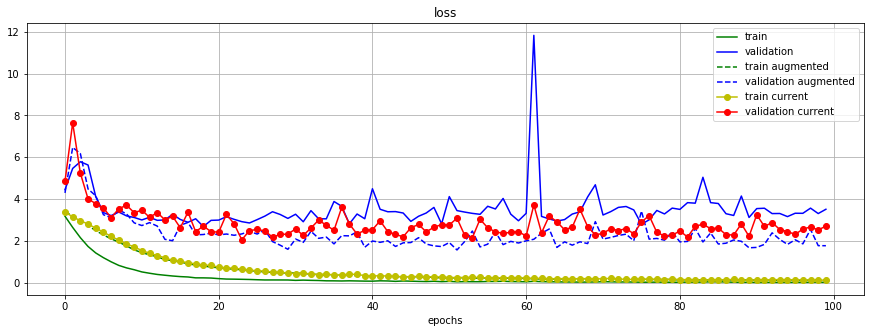

In [30]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['loss'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_loss'],'b-',label='validation')
plt.plot(history_dict_augmented['loss'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_loss'],'b--',label='validation augmented')
plt.plot(history_dict['loss'],'yo-',label='train current')
plt.plot(history_dict['val_loss'],'ro-',label='validation current')
plt.title('loss')
plt.xlabel('epochs')
plt.legend()
#plt.xticks(range(100),range(1,101))
plt.grid(True)

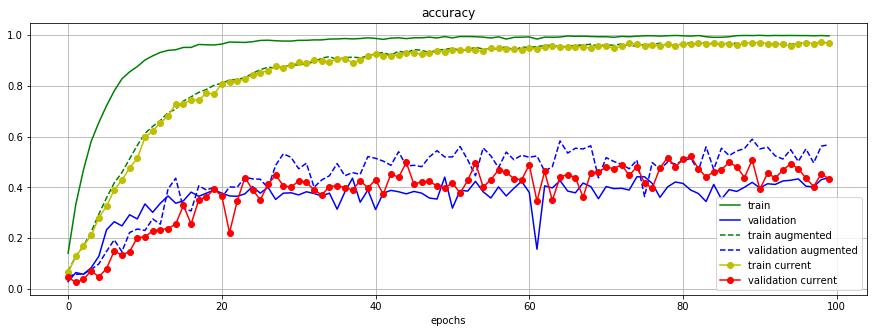

In [31]:
plt.figure(figsize=(15,5))
plt.plot(history_dict_unaugmented['accuracy'],'g-',label='train')
plt.plot(history_dict_unaugmented['val_accuracy'],'b-',label='validation')
plt.plot(history_dict_augmented['accuracy'],'g--',label='train augmented')
plt.plot(history_dict_augmented['val_accuracy'],'b--',label='validation augmented')
plt.plot(history_dict['accuracy'],'yo-',label='train current')
plt.plot(history_dict['val_accuracy'],'ro-',label='validation current')
plt.legend()
plt.xlabel('epochs')
plt.title('accuracy')
#plt.xticks(range(20),range(1,21))
plt.grid(True)

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

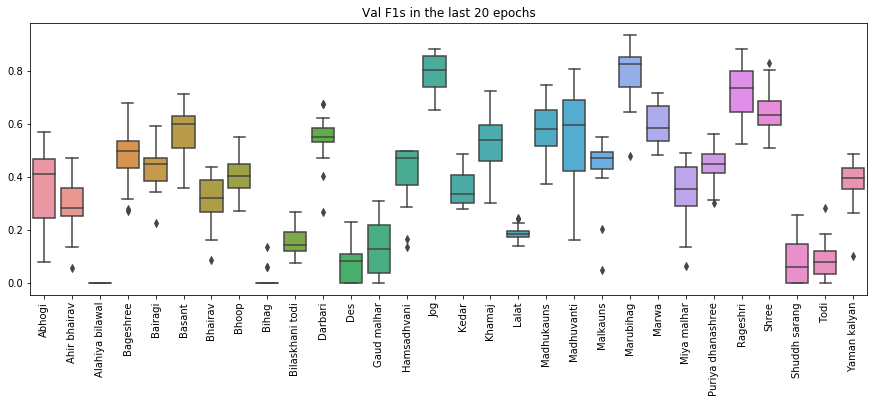

In [32]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_unaugmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

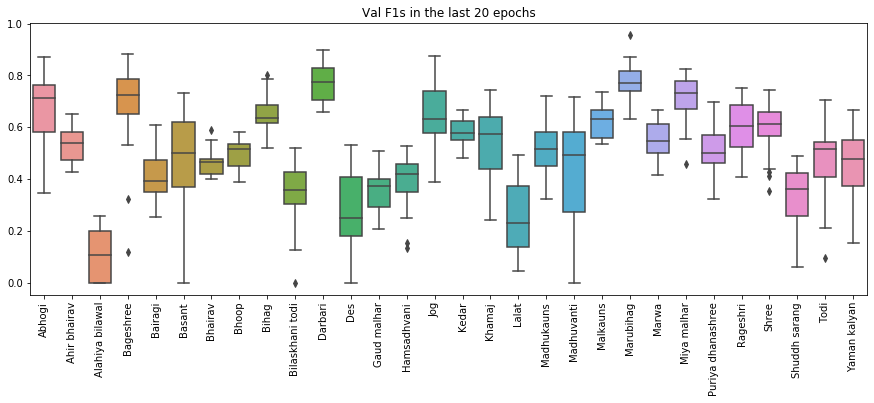

In [33]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict_augmented['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

Text(0.5, 1.0, 'Val F1s in the last 20 epochs')

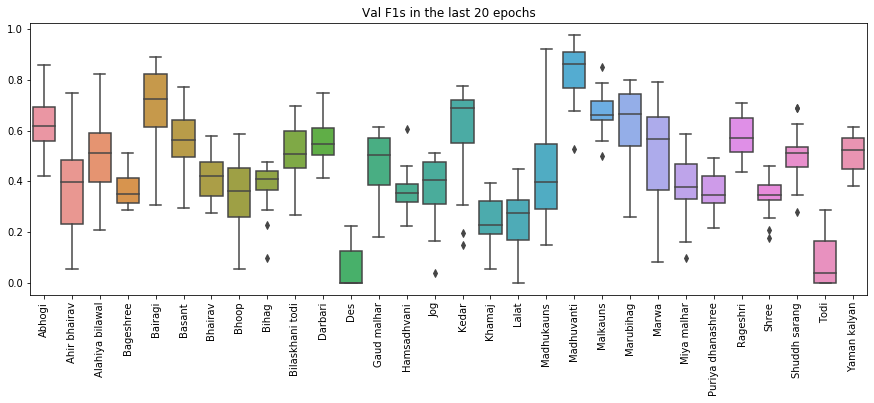

In [34]:
import pandas as pd
import seaborn as sns
fig=plt.figure(figsize=(15,5))
f1s=pd.DataFrame({ragas_reverse_idx[i]:history_dict['val_F1_{}'.format(i)][-20:] for i in range(30)})
ax=sns.boxplot( data=f1s)
ax.get_xticklabels()
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Val F1s in the last 20 epochs')

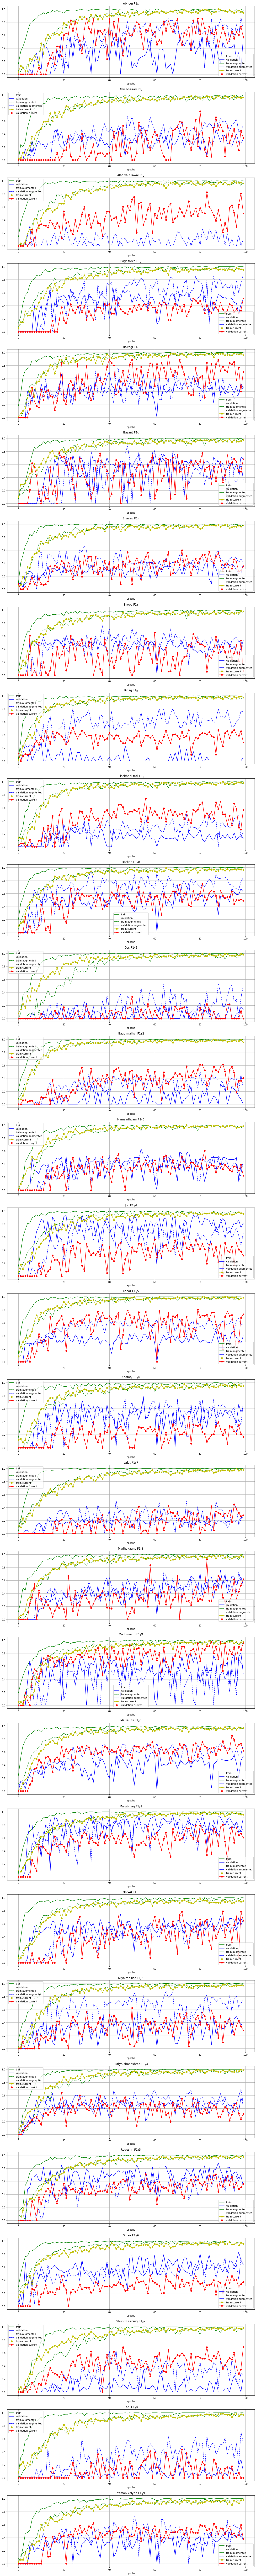

In [35]:
plt.figure(figsize=(15,5*30))
for i in range(30):
    plt.subplot(30,1,i+1)
    plt.plot(history_dict_unaugmented['F1_{}'.format(i)],'g-',label='train')
    plt.plot(history_dict_unaugmented['val_F1_{}'.format(i)],'b-',label='validation')
    plt.plot(history_dict_augmented['F1_{}'.format(i)],'g--',label='train augmented')
    plt.plot(history_dict_augmented['val_F1_{}'.format(i)],'b--',label='validation augmented')
    plt.plot(history_dict['F1_{}'.format(i)],'yo-',label='train current')
    plt.plot(history_dict['val_F1_{}'.format(i)],'ro-',label='validation current')
    plt.title(r'{raga_name} F1$_{raga_id}$'.format(raga_id=i,raga_name=ragas_reverse_idx[i]))
    plt.xlabel('epochs')
    plt.legend()
    #plt.xticks(range(20),range(1,21))
    plt.grid(True)
plt.tight_layout()

In [36]:
y_pred=np.argmax(model.predict(X_val),axis=-1)
y_true=y_val

In [37]:
cm=tf.math.confusion_matrix(y_true,y_pred,dtype=tf.float32,num_classes=30)


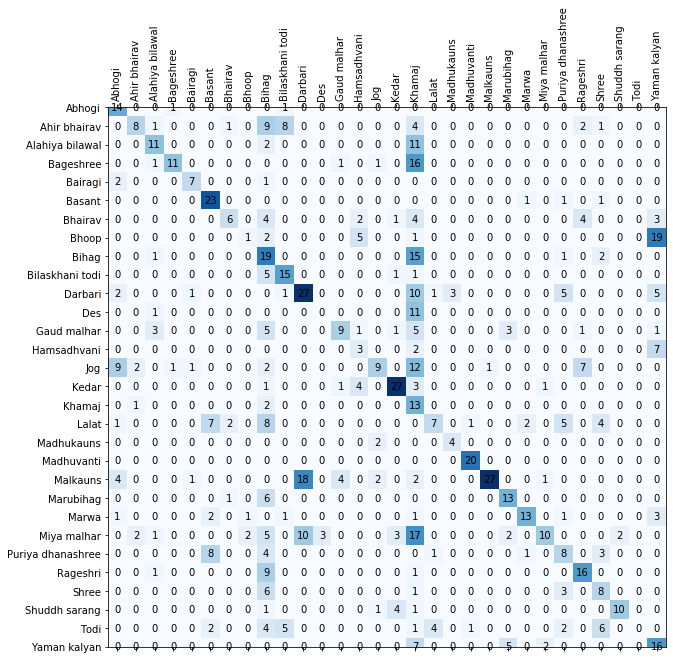

In [38]:
fig, ax = plt.subplots(figsize=(10,10))


cm_matrix = cm.numpy().astype(np.int32)

ax.matshow(cm_matrix, cmap=plt.cm.Blues)

for i in range(30):
    for j in range(30):
        c = cm_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center',size=10)
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.yticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=0)
plt.show()

In [39]:
def process_confusion_matrix(cm):
    "returns precision, recall and f1 along with overall accuracy"
    diag_part=tf.linalg.diag_part(cm)
    precision=diag_part/(tf.reduce_sum(cm,0)+tf.constant(1e-15))
    recall=diag_part/(tf.reduce_sum(cm,1)+tf.constant(1e-15))
    f1=2*precision*recall/(precision+recall+tf.constant(1e-15))
    return precision,recall,f1

In [40]:
precision,recall,f1=process_confusion_matrix(cm)

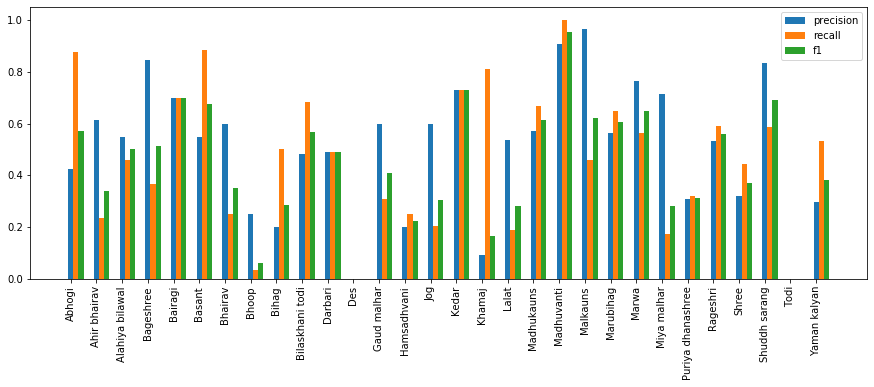

In [41]:
fig=plt.figure(figsize=(15,5))
plt.bar(np.arange(30),precision.numpy(),width=.2,label='precision')
plt.bar(np.arange(30)+.2,recall.numpy(),width=.2,label='recall')
plt.bar(np.arange(30)+.4,f1.numpy(),width=.2,label='f1')
plt.xticks(range(30),[ragas_reverse_idx[i] for i in range(30)],rotation=90)
plt.legend()
plt.show()

# work related to periodic padding

Based on https://stackoverflow.com/questions/39088489/tensorflow-periodic-padding

In [301]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([4, 3]), TensorShape([6, 4]))

In [302]:
result=tf.matmul(pre,a)
result

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [308]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9],[10,11,12]])[tf.newaxis,...,tf.newaxis]
pre = tf.constant([[0, 0,0,1], [1, 0, 0,0], [0, 1, 0,0], [0, 0, 1,0],[0,0,0,1], [1, 0, 0,0]])
a.shape,pre.shape

(TensorShape([1, 4, 3, 1]), TensorShape([6, 4]))

In [310]:
tf.transpose(tf.tensordot(pre,a,axes=[1,1]),(1,0,2,3))[0,:,:,0]

<tf.Tensor: shape=(6, 3), dtype=int32, numpy=
array([[10, 11, 12],
       [ 1,  2,  3],
       [ 4,  5,  6],
       [ 7,  8,  9],
       [10, 11, 12],
       [ 1,  2,  3]], dtype=int32)>

In [316]:
pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0))

In [322]:
class PeriodicPadding(keras.layers.Layer):
    def call(self,x):
        pre=tf.constant(np.diag(np.ones(12)).take([11,0,1,2,3,4,5,6,7,8,9,10,11,0],axis=0),dtype=np.float32)
        return tf.transpose(tf.tensordot(pre,x,axes=[1,1]),(1,0,2,3))

In [323]:
pp=PeriodicPadding()


In [328]:
next(iter(train_data))[0][...,tf.newaxis]

<tf.Tensor: shape=(32, 12, 1500, 1), dtype=float32, numpy=
array([[[[0.35395238],
         [0.62483937],
         [0.2514335 ],
         ...,
         [0.03919563],
         [0.02934529],
         [0.04388006]],

        [[0.8546381 ],
         [1.        ],
         [1.        ],
         ...,
         [0.04332115],
         [0.05731897],
         [0.0764455 ]],

        [[1.        ],
         [0.41365883],
         [0.18235262],
         ...,
         [0.84097314],
         [1.        ],
         [1.        ]],

        ...,

        [[0.26271972],
         [0.18089055],
         [0.0787217 ],
         ...,
         [0.09863921],
         [0.1284486 ],
         [0.08776184]],

        [[0.09208088],
         [0.05293678],
         [0.01514117],
         ...,
         [0.11066498],
         [0.06546266],
         [0.09747966]],

        [[0.15809135],
         [0.20290934],
         [0.01715337],
         ...,
         [0.01311859],
         [0.00853989],
         [0.01680734]]],


 

In [329]:
pp(next(iter(train_data))[0][...,tf.newaxis])

<tf.Tensor: shape=(32, 14, 1500, 1), dtype=float32, numpy=
array([[[[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]],

        [[0.01490354],
         [0.0233238 ],
         [0.05875514],
         ...,
         [0.9334802 ],
         [0.6985323 ],
         [0.5537118 ]],

        ...,

        [[0.02656923],
         [0.02724202],
         [0.02169165],
         ...,
         [0.4590119 ],
         [0.10448112],
         [0.02082583]],

        [[0.00452717],
         [0.00400506],
         [0.00686717],
         ...,
         [1.        ],
         [0.11782621],
         [0.03282115]],

        [[0.00503029],
         [0.00600811],
         [0.01264145],
         ...,
         [0.79746526],
         [0.2563728 ],
         [0.11950074]]],


 

In [335]:
c=keras.layers.Conv2D(5,(3,3), padding='valid')

In [336]:
c(pp(next(iter(train_data))[0][...,tf.newaxis]))

<tf.Tensor: shape=(32, 12, 1498, 5), dtype=float32, numpy=
array([[[[-8.96642953e-02,  1.67192012e-01,  1.22336112e-01,
          -1.19068444e-01,  9.58066359e-02],
         [-3.46585698e-02,  7.98996314e-02,  4.03669477e-02,
          -4.02128436e-02,  3.63214836e-02],
         [-2.91647911e-02,  6.70691654e-02,  2.11968012e-02,
          -1.92416068e-02,  2.24674847e-02],
         ...,
         [-1.34937856e-02,  3.23149301e-02, -1.19507752e-01,
           4.22342382e-02, -1.86150316e-02],
         [-2.89242696e-02, -1.16442721e-02, -1.39085233e-01,
           3.14064734e-02, -4.74732667e-02],
         [ 1.53264939e-03, -1.27264662e-02, -1.15292117e-01,
          -2.16421927e-03, -1.15130302e-02]],

        [[-3.63824517e-02, -7.21778767e-03, -6.31002188e-02,
           7.43871881e-03, -7.56851304e-03],
         [-3.52892838e-03,  1.77940354e-02, -3.32056433e-02,
           2.14235857e-03,  1.07655795e-02],
         [-2.26242933e-02,  1.72086544e-02, -5.05561940e-02,
           1.655

Should try the alternate method which is a bit memory heavy compare to the above



In [360]:
a = tf.constant([[1,2,3],[4,5,6],[7,8,9]])[tf.newaxis,...,tf.newaxis]
b = tf.tile(a, [1,3, 1,1])
result = b[:,2:7, :,:]

In [362]:
result[0,:,:,0]

<tf.Tensor: shape=(5, 3), dtype=int32, numpy=
array([[7, 8, 9],
       [1, 2, 3],
       [4, 5, 6],
       [7, 8, 9],
       [1, 2, 3]], dtype=int32)>